In [4]:
# will simulate from a model file, and plot some basic behavioral and nueral things, to show data structure

import pickle, json, sys
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt

from dynamics.process.rnn import wt_protocols
from dynamics.analysis import wt_analysis as wta
from dynamics.process.rnn import parse, parse_state
from dynamics.vis import wt_vis
from dynamics.utils import utils

workdir='/Users/dhocker/projects/kind_cl/'
dbase = '/Users/dhocker/projects/dynamics/results/20231003/'

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# simulate from .model file

#define which RNN to grab
num = 33  # RNN number
s_idx = 0  # CL type (0 = kind + shaping, 1 = shaping, 2 = no shaping)
tphase = 5 # phase of training (6:freeze block, 5:block, 4:catch, 3:nocatch, 2:pred, 1:hard kind, 0 simple kind:)
idx = 10 # idx within phase
epoch = 'wait'  # epoch within trial to handle dynamics. 'wait','start','iti'. 

#get .model name


d = utils.getfnames(num, s_idx, tphase, idx, dbase=dbase)
modelname = d['model']
print(modelname)
configname = workdir+'dynamics/analysis/block.cfg'

# simulate. will print out trial number at end of every minibatch. suppress by changing to displevel=4 in config file
dat = wt_protocols.sim_task(modelname, configname=configname, simtype='task', task_seed=101)

/Users/dhocker/projects/dynamics/results/20231003/full_cl/33/rnn_curric_33_block_10.model
uniqueops: adam_fname not defined in config. using default
0
10
22
34
49
61
69
83
92
104
120
129
140
150
161
171
181
194
205
217
225
234
243
258
269
279
291
300
310
321
332
343
357
365
373
384
393


In [9]:
#what does the data look like
print(dat.keys())

dict_keys(['rewvols', 'iscatch', 'blocks', 'outcomes', 'actions', 'wt', 'pi', 'values', 'grad_all', 'rewards', 'tmesh', 'w_all', 'theta', 'loss', 'loss_aux', 'states', 'inputs', 'rewards_pertrial', 'env', 'rewardrate_pergradstep', 'reward_delay', 'ops', 'preds', 'outputs_supervised', 'state_reset_idx', 'annealed_weights', 'outputs_sham'])


In [14]:
print(np.array(dat['preds']).shape)

test = np.array(dat['preds']).reshape((-1,3))
test.shape

(8, 500, 1, 3)


(4000, 3)

high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank


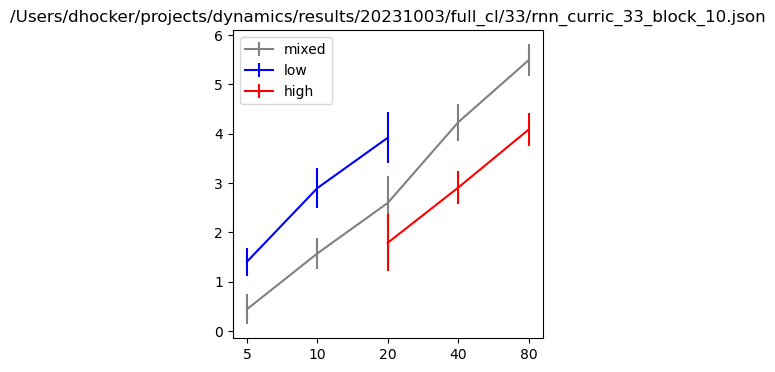

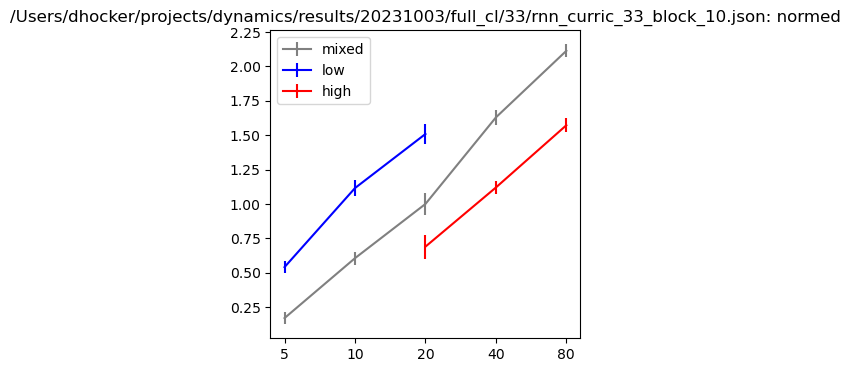

In [8]:
# show some behavior. the sign rank tests require > 5 samples per type (i.e., 20ul samples in high and low blocks)
# and will fail otherwise. set number of trials in config to higher to avoid this error (ns = 10000), but long runtime
ops = utils.opsbase()
wt_dict, linreg, numdict, rho_all, ops = wta.parsesimulation(dat, ops)
fig, fig2 = wt_vis.plotblocks(wt_dict, name=d['dat'])

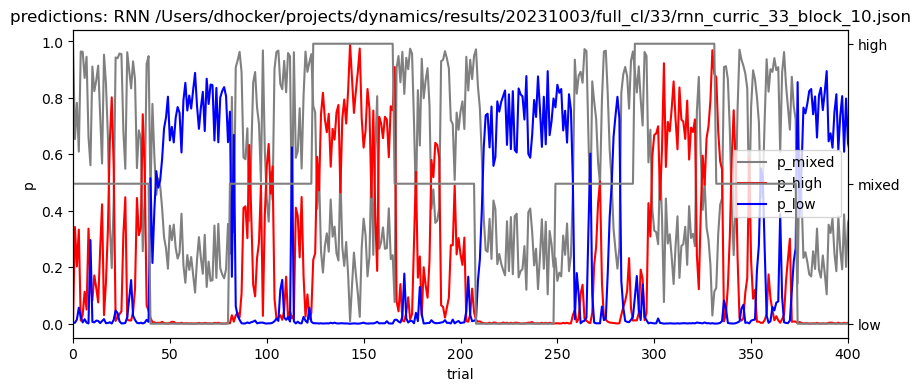

In [17]:
# show prediction ability

#preprocess
sflat, inp, tdict = parse.get_trialtimes(dat)
warpstate = False
preds = dat['preds']
rew = dat['rewvols']
inp = np.array([np.squeeze(np.squeeze(k[0].detach().numpy())) for k in inp])
offers = inp[inp[:,0]>0,0]

#sometimes there is a fencepost error. maybe a trial not finishing?
nx = min([len(tdict['start']), len(offers)])

preds_ontrial = np.zeros((nx,3))
predflat = []
for k in preds:
    predflat.extend(k)
    
predflat = np.array(preds).reshape((-1,3))


for k in range(nx):
    idx = tdict['start'][k] # for block prediction
    preds_ontrial[k,:] = softmax(predflat[idx])


#the plot itself
fig = plt.figure(figsize=(10,4))
Vlab = ['p_mixed','p_high','p_low']

block_redo = np.array(dat['blocks'])
block_redo[block_redo==1] = 10
block_redo[block_redo==2] = -10
block_redo[block_redo==10] = 1
block_redo[block_redo==-10] = -1

colors = ['gray','red','blue', 'brown','brown']
for k in range(3):
    #plt.plot(utils.mwa(preds_ontrial[:,k],10),label=Vlab[k], color = colors[k])
    plt.plot(preds_ontrial[:,k],label=Vlab[k], color = colors[k])

plt.xlabel('trial')
plt.ylabel('p')
ax = plt.gca()
ax2=plt.gca().twinx()
ax2.plot(block_redo,'gray')
ax2.set_yticks([0,1,-1],labels=['mixed','high','low'])
plt.title('predictions: RNN ' + d['dat'])
plt.xlim([0,400])
ax.legend()
plt.show()

In [21]:
dat.keys()

dict_keys(['rewvols', 'iscatch', 'blocks', 'outcomes', 'actions', 'wt', 'pi', 'values', 'grad_all', 'rewards', 'tmesh', 'w_all', 'theta', 'loss', 'loss_aux', 'states', 'inputs', 'rewards_pertrial', 'env', 'rewardrate_pergradstep', 'reward_delay', 'ops', 'preds', 'outputs_supervised', 'state_reset_idx', 'annealed_weights', 'outputs_sham'])

37
(18500, 3)


In [33]:
# some very simple neural activity. sample units, conditioned on block. snippets from dynamics_preprocess_suite()

print('flatten states and get trial times')
sflat, inp, tdict = parse.get_trialtimes(dat)

print('package behavioral data into dict')
blocks = np.array(dat['blocks'])  # block type, per trial
outcomes = np.array(dat['outcomes']) # hit, opt-out, or violation
inp = np.array(
            [np.squeeze(np.squeeze(k[0].detach().numpy())) for k in inp])
offers = inp[inp[:, 0] > 0, 0]  # offer size, log space
output = dat['outputs_supervised']  # outputs for kindergarten costs, per timepoint
preds = dat['preds']  # log-prob of each block, per timepoint
output_flat = []
pred_flat = []
for j in output:
    output_flat.extend(j)
for j in preds:
    pred_flat.extend(j)
    
behdict = {'offers': offers, 'output': output_flat, 'blocks': blocks, 'tdict': tdict,
                   'outcomes': outcomes, 'preds': pred_flat, 'task': 'task'}

print('process neural data: get wait epoch data into nice form, and remove outlier data')
statedict, behdict = parse_state.postprocess4dynamics(sflat, behdict, warpstate=False, Ttrial=256 * 3,
                                                              zeromean=False, epoch='wait')


print('getting trials for each volume offer on opt-out trials across all blocks')
statedict.keys()
ns = 1000

offermask = [(outcomes[:ns] == 0) & (offers[:ns] == k) for k in np.log([5,10,20,40,80])]



flatten states and get trial times
package behavioral data into dict
process neural data: get wait epoch data into nice form, and remove outlier data


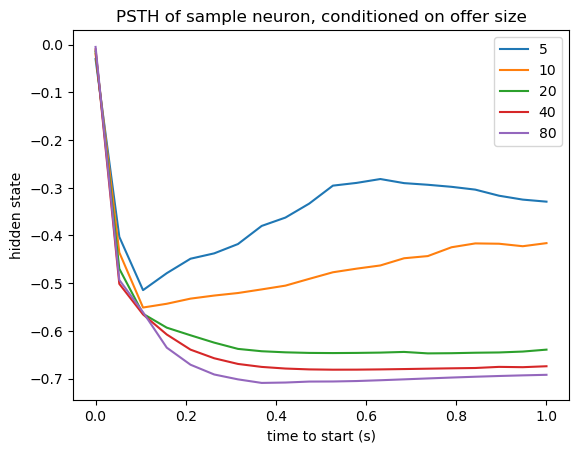

In [88]:
# plot
statedict.keys()
ns = 1000 # number of trials
nt = 20  # number of timepoints to grab. dt = 0.05, so 1s of data
neur_idx = 10 # which neuron

offermask = [(outcomes[:ns] == 0) & (offers[:ns] == k) for k in np.log([5,10,20,40,80])]


ofcdat = np.squeeze(statedict['sflat_ofc_h'])

condlist = []
for j in offermask:
    ts = tdict['start'][np.argwhere(j)[:,0]]
    te = ts + nt
    ns_j = len(ts)
    cond_j = np.zeros((nt,))
    for k in range(ns_j):
        cond_j += ofcdat[ts[k]:te[k],neur_idx]
    cond_j = cond_j/ns_j
    condlist.append(cond_j)

labs = ['5','10','20','40','80']
tvec = np.linspace(0,0.05*nt,nt)
[plt.plot(tvec,condlist[k], label=labs[k]) for k in range(5)]
plt.title('PSTH of sample neuron, conditioned on offer size')
plt.xlabel('time to start (s)')
plt.ylabel('hidden state')
plt.legend()
plt.show()
